In [63]:
import tifffile as tf
from scipy import ndimage
from scipy import signal

import numpy as np
import pandas as pd
import numpy.polynomial.polynomial as P

import os

import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
src = '../hpcc/'
dst = '../hpcc/traditional/'

wsrc = src + 'clean/'
tsrc = src + 'watershed/'
rsrc = src + 'rotated/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

In [122]:
idname = '2011SBb'

rownum = 3
treenum = 9
nutnum = 9

bname = idname + '_R{}_T{}'.format(rownum, treenum)
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

2011SBb_R3_T9_009
../hpcc/traditional/2011SBb_R3_T9/


In [123]:
tissuefiles = tsrc + bname + '/' + fname + '_'
meat = tf.imread(tissuefiles + 'meat.tif')

In [124]:
bimg = meat.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
kerarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
kervoxarea = np.sum(border)

print('Border made of\t', kervoxarea, 'pixels\n')
print('Nut surface area:\t', np.round(kerarea, 2), 'mm^2')
print('Approx by a square of size:\t', np.round(np.sqrt(kerarea),2), 'mm')

Border made of	 607781 pixels

Nut surface area:	 5785.47 mm^2
Approx by a square of size:	 76.06 mm


In [125]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, _, _ = data[13]
tipvox = data[14]
rtipvox = data[15]
feretd = data[18]
nutvol, nutarea, nutvoxarea = data[19]
#nutvoxarea *= resol**2
chnutarea, chnutvol, _ = data[20]

tipvox[0] *= 1 + (-2*rotX)

datapoints = np.asarray(np.nonzero(border))
datapoints = datapoints - np.mean(datapoints, axis=1).reshape(-1,1)
datapoints *= resol

mcoords = rotxyz @ datapoints

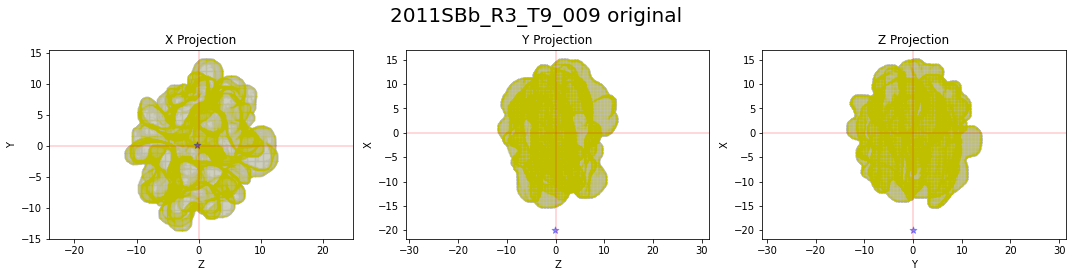

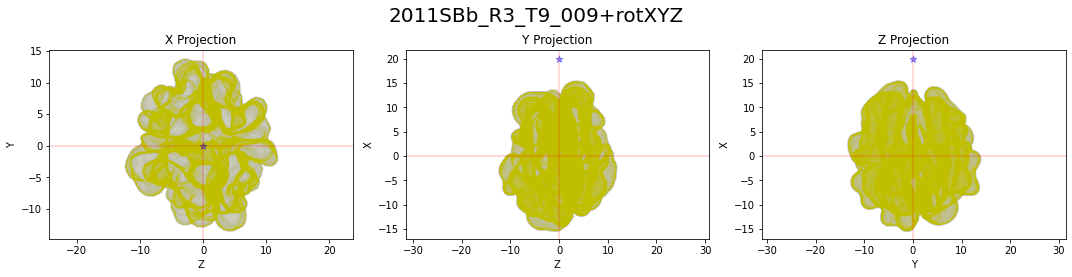

In [126]:
fig, ax = wnut.plot_3Dprojections(datapoints, fname + ' original', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(tipvox[2], tipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(tipvox[2], tipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(tipvox[1], tipvox[0], marker='*', s=50, c='b', alpha=.4);

fig, ax = wnut.plot_3Dprojections(mcoords, fname + '+rotXYZ', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', s=50, c='b', alpha=.4);

In [48]:
kminis = np.min(mcoords, axis=1)
kmaxes = np.max(mcoords, axis=1)

c,b,a = np.sort(kmaxes - kminis)*.5

krumbein = np.cbrt(b*c/(a*a))
corey = c/np.sqrt(a*b)
sneed = np.cbrt(c*c/(a*b))
janke = c/np.sqrt((a**2 + b**2 + c**2)/3)

print('{:.2f}\t{:.2f}\t{:.2f}'.format(a,b,c))
print(np.round([krumbein, corey, sneed, janke, c/a],3), sep='\t')

16.37	13.84	12.25
[0.858 0.814 0.872 0.859 0.748]


# Bottom clamp

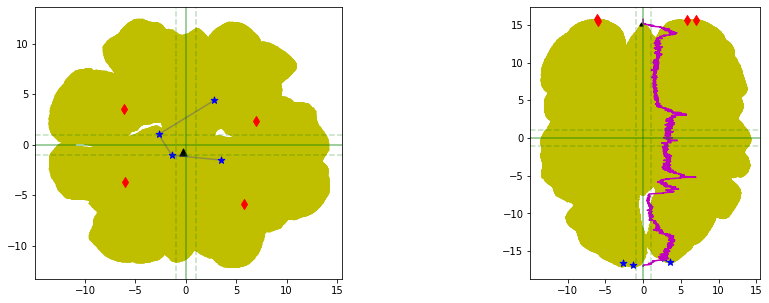

In [62]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=True)
ax = np.atleast_1d(ax).ravel()
i = 0
ax[i].scatter(mcoords[1], mcoords[2], s=2, color='y', alpha=1, marker='.')
ax[i].scatter(legy, legz, s=50, color='b', marker='*');
ax[i].scatter(army, armz, s=50, color='r', marker='d');
ax[i].scatter(head[1], head[2], s=50, color='k', marker='^');
ax[i].plot(legy, legz, color='b', alpha=0.25);
i += 1
ax[i].scatter(mcoords[1], mcoords[0], s=2, color='y', alpha=1, marker='.')
ax[i].scatter(legy, legx, s=50, color='b', marker='*');
ax[i].scatter(army, armx, s=50, color='r', marker='d');
ax[i].scatter(head[1], head[0], s=10, color='k', marker='^');
ax[i].plot(7*hist/np.max(hist), bins[1:], c='m')

for i in range(len(ax)):
    ax[i].set_aspect('equal');
    ax[i].axvline(0, c='g',alpha=0.5)
    ax[i].axhline(0,c='g',alpha=0.5);
    
    ax[i].axvline(-kk, c='g',alpha=0.25, ls='--')
    ax[i].axhline(-kk,c='g',alpha=0.25, ls='--');
    ax[i].axvline( kk, c='g',alpha=0.25, ls='--')
    ax[i].axhline( kk,c='g',alpha=0.25, ls='--');

In [49]:
kk = 1

leg0y = np.min(mcoords[0,(mcoords[1] > kk) & (mcoords[2] > kk)])
leg0x, leg0y, leg0z = mcoords[:,mcoords[0] == leg0y].squeeze()

leg1y = np.min(mcoords[0,(mcoords[1] < -kk) & (mcoords[2] > kk)])
leg1x, leg1y, leg1z = mcoords[:,mcoords[0] == leg1y].squeeze()

leg2y = np.min(mcoords[0,(mcoords[1] < -kk) & (mcoords[2] < -kk)])
leg2x, leg2y, leg2z = mcoords[:,mcoords[0] == leg2y].squeeze()

leg3y = np.min(mcoords[0,(mcoords[1] > kk) & (mcoords[2] < -kk)])
leg3x, leg3y, leg3z = mcoords[:,mcoords[0] == leg3y].squeeze()

legx = np.asarray([leg0x, leg1x, leg2x, leg3x])
legy = np.asarray([leg0y, leg1y, leg2y, leg3y])
legz = np.asarray([leg0z, leg1z, leg2z, leg3z])
print('X:\t', legx, '\nY:\t', legy, '\nZ:\t', legz, sep='')

X:	[-15.94212747 -16.59429543 -16.86022101 -16.48543025]
Y:	[ 2.79998133 -2.69798113 -1.37914846  3.5033111 ]
Z:	[ 4.37687875  1.00973903 -1.04769959 -1.52523937]


In [50]:
arm0y = np.max(mcoords[0,(mcoords[1] > kk) & (mcoords[2] > kk)])
arm0x, arm0y, arm0z = mcoords[:,mcoords[0] == arm0y].squeeze()

arm1y = np.max(mcoords[0,(mcoords[1] < -kk) & (mcoords[2] > kk)])
arm1x, arm1y, arm1z = mcoords[:,mcoords[0] == arm1y].squeeze()

arm2y = np.max(mcoords[0,(mcoords[1] < -kk) & (mcoords[2] < -kk)])
arm2x, arm2y, arm2z = mcoords[:,mcoords[0] == arm2y].squeeze()

arm3y = np.max(mcoords[0,(mcoords[1] > kk) & (mcoords[2] < -kk)])
arm3x, arm3y, arm3z = mcoords[:,mcoords[0] == arm3y].squeeze()

armx = np.asarray([arm0x, arm1x, arm2x, arm3x])
army = np.asarray([arm0y, arm1y, arm2y, arm3y])
armz = np.asarray([arm0z, arm1z, arm2z, arm3z])
print('X:\t', armx, '\nY:\t', army, '\nZ:\t', armz, sep='')

X:	[15.68189749 15.7208911  15.44597489 15.60306746]
Y:	[ 6.9503113  -6.15439672 -6.03361188  5.80072297]
Z:	[ 2.32544111  3.51856065 -3.70165921 -5.91924062]


In [51]:
head = np.max(mcoords[0,(np.abs(mcoords[1]) < kk) & (np.abs(mcoords[2]) < kk)])
head = mcoords[:,mcoords[0] == head].squeeze()

In [76]:
signal.find_peaks(-hist[50:-50], distance = 50)[0]

array([  9,  97, 163, 214, 290, 350, 448, 522, 580, 631, 689, 743, 793,
       851])

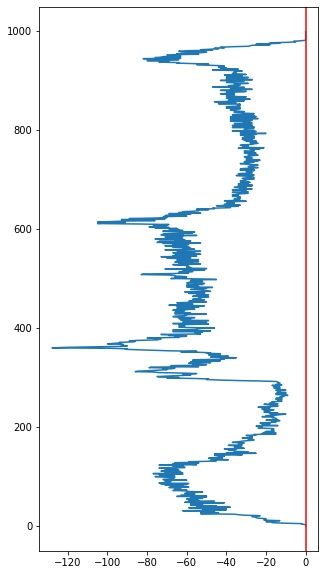

In [68]:
# lower arch height

kk = 1
hist, bins = np.histogram(mcoords[0,(np.abs(mcoords[1]) < kk)],# & (np.abs(mcoords[2]) < kk)], 
                          bins=np.linspace(kminis[0], kmaxes[0], 1000),
                          density = False)
fig, ax = plt.subplots(1,1,figsize=(5,10), sharex=True)
ax = np.atleast_1d(ax).ravel()
i = 0
ax[i].plot(-hist, range(len(hist)))
ax[i].axvline(0, c='r')

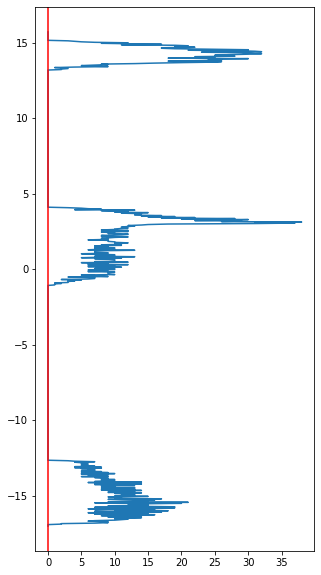

In [60]:
# central piece

kk = 1
hist, bins = np.histogram(mcoords[0,(np.abs(mcoords[1]) < kk) & (np.abs(mcoords[2]) < kk)], 
                          bins=np.linspace(kminis[0], kmaxes[0], 1000),
                          density = False)
fig, ax = plt.subplots(1,1,figsize=(5,10), sharex=True)
ax = np.atleast_1d(ax).ravel()
i = 0
ax[i].plot(hist, bins[1:])
ax[i].axvline(0, c='r')

In [25]:
print(leg0y - leg1y)
print(leg3y - leg2y)

print(arm0y - arm1y)
print(arm3y - arm2y)

foo = np.argmax(np.abs(head[0] - armx))
print(head[0] - armx[foo])

9.596265087641491
10.958482137842509
12.897806569395492
11.572818454942276
-1.9836414947555951


In [106]:
print(leg0y - leg1y)
print(leg3y - leg2y)

print(arm0y - arm1y)
print(arm3y - arm2y)

foo = np.argmax(np.abs(head[0] - armx))
print(head[0] - armx[foo])

5.497962451065023
4.882459551064663
13.104708018513204
11.834334856808546
-0.5924246862456926
